# Predictions Analysis - FNN V15 Large
This model performs no better than fnn_v14 or fnn_v15_small

In [1]:
import torch
import re

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import brier_score_loss, confusion_matrix, f1_score, log_loss
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

In [2]:
# NOTE: Update this cell before running!!

# Model Version to analyze results from
model_version = 'fnn_v15_large'

# Directory to the repository on your computer
repo_dir = '/Users/johnjoba/local_git_repos/sts_cockpit'

In [3]:
# Load in the master card list and master relic list
f = open(f'{repo_dir}/data/master_lists/master_card_list.txt', 'r')
master_card_list = f.readlines()
f.close()

# Pull in the master card list to ensure each file has the same schema
f = open(f'{repo_dir}/data/master_lists/master_relic_list.txt', 'r')
master_relic_list = f.readlines()
f.close()

# Process lists into dictionaries with value 1 to ensure all items are captured
master_card_list = [re.sub('\n', '', card) for card in master_card_list]
master_relic_list = [re.sub('\n', '', relic) for relic in master_relic_list]

# List of card & relic name changes to current game
recodes = {
    'underhanded_strike':'sneaky_strike', 
    'underhanded_strike_u':'sneaky_strike_u',
    'wireheading':'foresight', 
    'wireheading_u':'foresight_u', 
    'conserve_battery':'charge_battery',
    'conserve_battery':'charge_battery_u', 
    'lockon':'bullseye',
    'lockon_u':'bullseye_u',
    'undo':'equilibrium',
    'undo_u':'equilibrium_u',
    'steam_power': 'steam_barrier',
    'steam_power_u':'steam_barrier_u',
    'molten_egg_2': 'molten_egg',
    'toxic_egg_2': 'toxic_egg',
    'frozen_egg_2': 'frozen_egg'
  }

# Recode the card and relic lists
master_card_list = [recodes[k] if k in recodes.keys() else k for k in master_card_list]
master_relic_list = [recodes[k] if k in recodes.keys() else k for k in master_relic_list]

In [4]:
# Setup device for loading model
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [5]:
# Load model
model = torch.jit.load(f'{repo_dir}/model_objects/production/{model_version}.pth').to(device)
model.eval()


RecursiveScriptModule(
  original_name=NeuralNetwork
  (flatten): RecursiveScriptModule(original_name=Flatten)
  (linear_relu_stack): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=Dropout)
    (3): RecursiveScriptModule(original_name=Linear)
    (4): RecursiveScriptModule(original_name=ReLU)
    (5): RecursiveScriptModule(original_name=Dropout)
    (6): RecursiveScriptModule(original_name=Linear)
    (7): RecursiveScriptModule(original_name=ReLU)
    (8): RecursiveScriptModule(original_name=Dropout)
    (9): RecursiveScriptModule(original_name=Linear)
    (10): RecursiveScriptModule(original_name=ReLU)
    (11): RecursiveScriptModule(original_name=Dropout)
    (12): RecursiveScriptModule(original_name=Linear)
    (13): RecursiveScriptModule(original_name=Sigmoid)
  )
)

In [6]:
# Load data
test_data = pd.read_csv(f'{repo_dir}/data/training_data/finetuning/test/test.csv', dtype = 'int8', header = 0)

train_data = pd.read_csv(f'{repo_dir}/data/training_data/finetuning/train/train.csv', dtype = 'int8', header = 0)

In [7]:
# gets the predicted values
with torch.no_grad():
    x = torch.from_numpy(test_data.drop('victory', axis = 1).to_numpy().astype(np.float32)).to(device)
    pred = model(x)
 
 # Load predictions into the test data set for comparison
test_data['probs'] = pred.cpu().numpy()
test_data['preds'] = np.int32(test_data['probs'] > 0.5)

with torch.no_grad():
    x = torch.from_numpy(train_data.drop('victory', axis = 1).to_numpy().astype(np.float32)).to(device)
    pred = model(x)
 
 # Load predictions into the test data set for comparison
train_data['probs'] = pred.cpu().numpy()
train_data['preds'] = np.int32(train_data['probs'] > 0.5)

In [8]:
# Calculate accuracy
print(f'Accuracy: {((sum(test_data['preds'] == test_data['victory']) / test_data.shape[0]) * 100):>0.2f}%')

Accuracy: 97.97%


In [9]:
# Run confusion matrix
# 0,0 = TN, 1,0 = FN, 1,1 = TP, 0,1 = FP
confusion_matrix(test_data['victory'], test_data['preds'], normalize='true')

# Recall is ~65%, meaning we identify ~2/3s of winning runs

array([[0.99353194, 0.00646806],
       [0.35363908, 0.64636092]])

In [10]:
# F1 Score (higher is better)
f1_score(test_data['victory'], test_data['preds'])

0.7171118466630745

In [11]:
# Log Loss (lower is better, should match test loss from train_model.py)
log_loss(test_data['victory'], test_data['probs'])

0.043934351458346246

In [12]:
# Calculates Brier Score (lower is better) to assess predicted probability calibration
print(f'Brier Score: {(brier_score_loss(test_data['victory'], test_data['probs'])):>0.4f}')

Brier Score: 0.0140


In [13]:
# Take a look through the top & bottom few decks to see what the model is thinking
for asc in [True, False]:
    print(f'Ascensing Order: {asc}')
    sorted = test_data.sort_values(by = ['probs'], ascending = True).copy()

    top_n = 5

    for i in range(top_n):
        temp = {k:v for k, v in sorted.iloc[i].to_dict().items() if v != 0}

        print(temp)

        print('-' * 15)

Ascensing Order: True


{'accuracy': 1.0, 'all_out_attack': 1.0, 'ascendersbane': 1.0, 'blade_dance': 1.0, 'blade_dance_u': 2.0, 'bouncing_flask': 1.0, 'catalyst': 1.0, 'cloak_and_dagger': 1.0, 'dagger_spray': 1.0, 'dash': 1.0, 'dodge_and_roll': 1.0, 'finisher': 1.0, 'flechettes': 1.0, 'flying_knee': 1.0, 'glass_knife': 1.0, 'infinite_blades': 2.0, 'neutralize': 1.0, 'phantasmal_killer': 1.0, 'setup': 1.0, 'sucker_punch': 1.0, 'survivor': 1.0, 'tactician': 1.0, 'darkstone_periapt': 1.0, 'eternal_feather': 1.0, 'neowsblessing': 1.0, "pandora's_box": 1.0, 'regal_pillow': 1.0, 'ring_of_the_snake': 1.0, 'smiling_mask': 1.0, 'the_silent': 1.0, 'probs': 1.1134974886584104e-11}
---------------
{'all_out_attack_u': 1.0, 'ascendersbane': 1.0, 'bane': 2.0, 'blade_dance': 2.0, 'burst': 1.0, 'caltrops_u': 1.0, 'choke': 1.0, 'dagger_throw': 1.0, 'flechettes': 1.0, 'footwork_u': 1.0, 'infinite_blades': 1.0, 'neutralize': 1.0, 'outmaneuver': 1.0, 'quick_slash': 1.0, 'survivor': 1.0, 'sneaky_strike': 2.0, 'ancient_tea_set': 

In [14]:
# Convenience fields for plotting later on
test_data['deck_size'] = test_data[master_card_list].sum(axis = 1)
test_data['character'] = 'unknown'
test_data.iloc[test_data['ironclad'] == 1, 867] = 'ironclad'
test_data.iloc[test_data['the_silent'] == 1, 867] = 'the_silent'
test_data.iloc[test_data['defect'] == 1, 867] = 'defect'
test_data.iloc[test_data['watcher'] == 1, 867] = 'watcher'


# Defect, Ironclad, The Silent, Watcher
sts_colors = ['#4CC9EC', '#E65252', '#A1AC4C', '#C389FF']

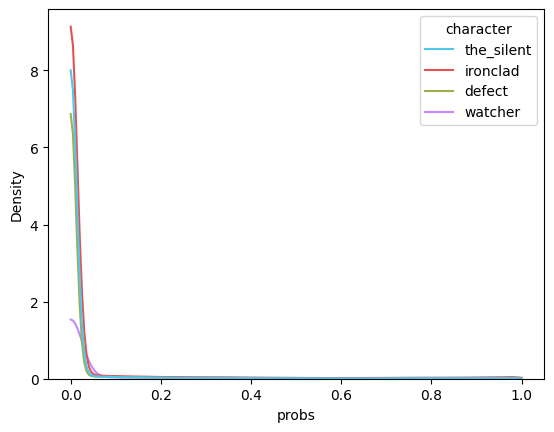

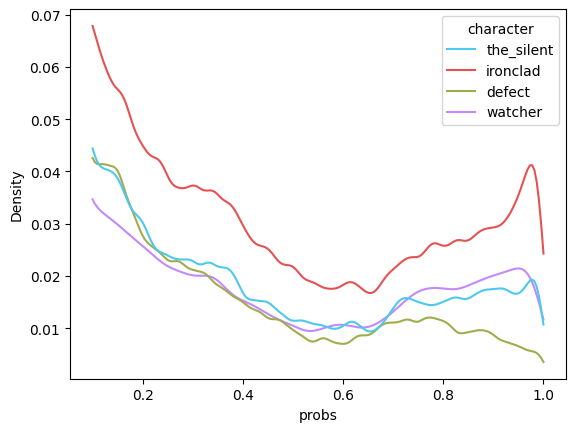

In [15]:
# Distribution of Predicted Win Rates
sns.kdeplot(test_data, x = 'probs', hue = 'character', palette = sts_colors, cut = 0, clip = [0, 1])
plt.show()

# With all the mass at 0, zooming in to look past 0.1 to see if there's any lift in prediected rate
sns.kdeplot(test_data, x = 'probs', hue = 'character', palette = sts_colors, cut = 0, clip = [0.1, 1])
plt.show()

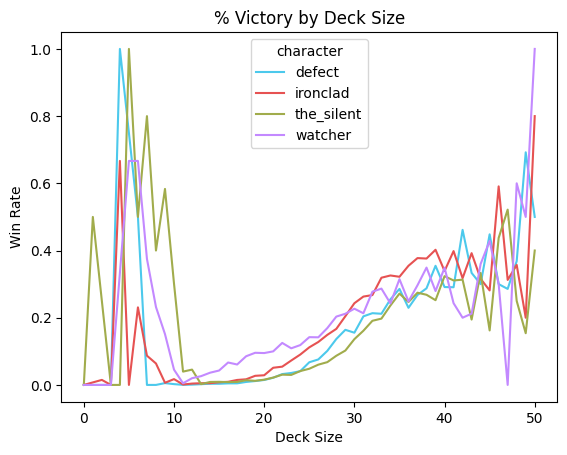

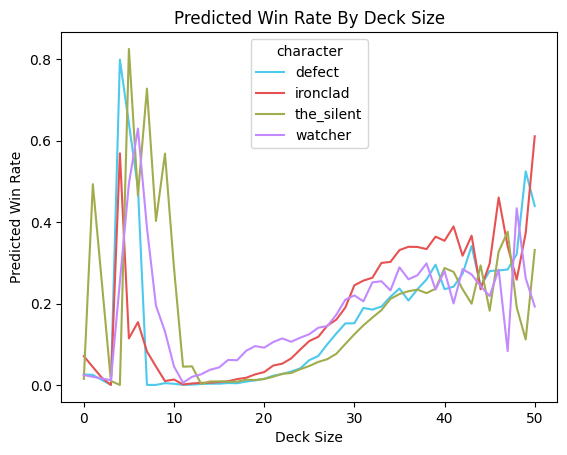

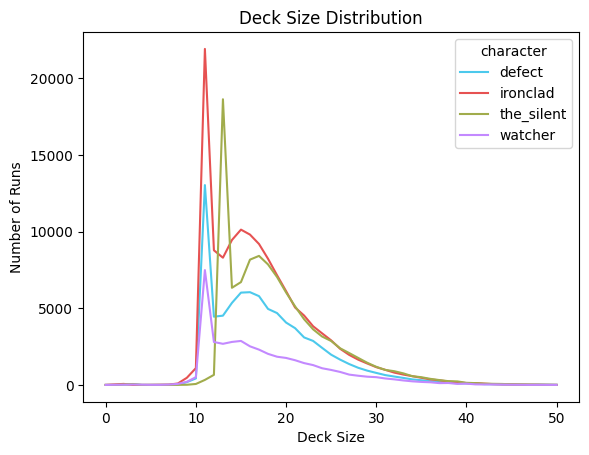

In [16]:
# It generally seems that more cards in the deck leads to a lower win rate. Winning decks seem to have fewer cards and a lot of relics
plot_df = test_data[test_data['deck_size'] <= 50][['deck_size', 'victory', 'character']].groupby(['character', 'deck_size']).mean()

sns.lineplot(data = plot_df, x = 'deck_size', y = 'victory', hue = 'character', palette = sts_colors).set_title('% Victory by Deck Size')
plt.ylabel('Win Rate')
plt.xlabel('Deck Size')
plt.show()

plot_df = test_data[test_data['deck_size'] <= 50][['deck_size', 'probs', 'character']].groupby(['character', 'deck_size']).mean()
sns.lineplot(data = plot_df, x = 'deck_size', y = 'probs', hue = 'character', palette = sts_colors).set_title('Predicted Win Rate By Deck Size')
plt.ylabel('Predicted Win Rate')
plt.xlabel('Deck Size')
plt.show()

plot_df = test_data[test_data['deck_size'] <= 50][['deck_size', 'victory', 'character']].groupby(['character', 'deck_size']).count()
sns.lineplot(data = plot_df, x = 'deck_size', y = 'victory', hue = 'character', palette = sts_colors).set_title('Deck Size Distribution')
plt.ylabel('Number of Runs')
plt.xlabel('Deck Size')
plt.show()

In [17]:
# What's the predicted win rate for each card?
# This is based on the presence of a given card in a deck NOT quantity or other cards present
win_rate_dict = {}

for card in master_card_list:
    win_rate = test_data[test_data[card] > 0]['probs'].mean()
    win_rate_dict[card] = win_rate

pd.DataFrame(
    {'card': [k for k in win_rate_dict.keys()], 
     'predicted_win_rate': [k for k in win_rate_dict.values()]}).sort_values(by = 'predicted_win_rate', ascending = False)

,card,predicted_win_rate
475,purity_u,0.579867
399,master_of_strategy_u,0.519909
183,deep_breath_u,0.446329
361,innerpeace_u,0.438724
322,grand_finale_u,0.431465
...,...,...
423,neutralize,0.014773
359,injury,0.013528
578,strike,0.012486
216,doubt,0.011888


In [18]:
# What's the predicted win rate for each relic?
win_rate_dict = {}

for relic in master_relic_list:
    win_rate = test_data[test_data[relic] > 0]['probs'].mean()
    win_rate_dict[relic] = win_rate

pd.DataFrame(
    {'relic': [k for k in win_rate_dict.keys()], 
     'predicted_win_rate': [k for k in win_rate_dict.values()]}).sort_values(by = 'predicted_win_rate', ascending = False)

,relic,predicted_win_rate
31,circlet,0.827122
25,cauldron,0.544439
88,melange,0.486083
156,theabacus,0.449967
82,mark_of_the_bloom,0.433567
...,...,...
95,neowsblessing,0.028879
129,ring_of_the_snake,0.025503
35,cracked_core,0.022439
63,gremlinmask,0.019364


In [19]:
# What's the predicted win rate for each character?
# Since it's A20, every deck has an ascenders bane. This entry reflects average win rate overall
win_rate_dict = {}

for character in ['ironclad', 'the_silent', 'defect', 'watcher', 'ascendersbane']:
    win_rate = test_data[test_data[character] > 0]['probs'].mean()
    win_rate_dict[character] = win_rate

pd.DataFrame(
    {'character': [k for k in win_rate_dict.keys()], 
     'predicted_win_rate': [k for k in win_rate_dict.values()]}).sort_values(by = 'predicted_win_rate', ascending = False)

,character,predicted_win_rate
3,watcher,0.074335
0,ironclad,0.039223
4,ascendersbane,0.037185
1,the_silent,0.029309
2,defect,0.026130


In [20]:
# Test out model calibration options to see if any are better than what we saw directly from the NN
# Success would mean that this number is lower than the brier score seen in the prior cell

# Non-parametric Isotonic Regression Calibration
ir = IsotonicRegression(y_min = 0, y_max = 1)
ir.fit(train_data['probs'], train_data['victory'])
print(f'Isotonic Brier Score: {(brier_score_loss(test_data['victory'], ir.predict(test_data['probs']) > 0.5)):>0.4f}')

# Logistic Regression Calibration
lr = LogisticRegression(penalty = None, tol = 1e-8)
lr.fit(train_data.iloc[:, 864:865], train_data['victory'])
print(f'Logistic Brier Score: {(brier_score_loss(test_data['victory'], lr.predict_proba(test_data.iloc[:, 864:865])[:,1] > 0.5)):>0.4f}')

# Takeaway: calibrated model is somehow worse than ANN. Either there is an error or best move is to continue without
# 8.26 : decided not to impement as it added complexity without improving results

Isotonic Brier Score: 0.0201
Logistic Brier Score: 0.0201
